# 영향력 모듈
작성일: 2019-07-30  
작성자: 윤현영

In [5]:
import boto3
import json
import pandas as pd
import seaborn as sns


df = pd.read_csv('data/postNprofile_new.csv')
df.drop('Unnamed: 0', inplace=True, axis=1)
df.head()

In [13]:
# reading posts from s3
def get_s3(filter_df):
    bucketName = 'instagram-post'
    s3 = boto3.resource('s3')
    my_bucket = s3.Bucket(bucketName)
    post = {}

    for json_file in my_bucket.objects.all():
        if not json_file.key.endswith('.json'):
            continue

        ID = json_file.key.replace('.json','')

        if ID not in filter_df['youtube'].values:
            continue

        content_object = s3.Object(bucketName, json_file.key)
        file_content = content_object.get()['Body'].read().decode('utf-8')
        data = json.loads(file_content)

        post[ID] = data
    
    return post

# # save comments as a json file
# with open('data/instagram_comment.json', 'w') as f:
#     json.dump(instagram_comment, f, ensure_ascii=False)

# Promoter Index
- 알려 (어딘지 알려주세요) 153개
LOOPHOLE: 인스타에도 좀소식알려주세용^^, 모르는거 잘 알려주기, 스케줄 알려주시고요, 마지막 사진이 알려주고 있어요
- 구매 (구매처가 어떻게 되나요, 태그된 곳에서 구매하면 되나요?, 구매했습니다! 등) 148개  
LOOPHOLE: 요가마트 구매해서 쓰고있는데 좀 딱딱해서 엄마가 오히려 허리가 아프다고 하시는데 좋은 방법 없을까요 ??
- 어디서 (어디서 사셨나요, 가방 어디꺼에요? 등) 417개. 소비와 관련되지 않은 댓글들이 많아서 제외하는 게 좋을듯  
LOOPHOLE: 어디 학교 나오셨어요? (여행간듯) 어디에요?, 어디갔지
- 정보 (오늘 입으신 옷 정보 좀요) 147개
- 궁금 257개

In [23]:
def aggregate_comment(postFile):
    '''
    s3에서 받은 postFile을 넣으면 각 인플루언서 별로 댓글의 텍스트를 합산하는 함수
    '''
    instagram_comment = {}
    for ID, model in post.items():
        unpacked = [p['comments'] for p in model if 'comments' in p.keys()] # first unpacking
        oneself = df.loc[df['youtube']==ID]['name'].iloc[0] # get username to check if it's self reply
        instagram_comment[ID] = [subitem['comment'] for item in unpacked 
                               for subitem in item if subitem['author'] != oneself] #second unpacking

    return instagram_comment

def promoted_comment(queryList, data):
    # mapping of <text of comment containing at least one query> - <influencer>
    for query in queryList:
        query_res = {comment: influencer for influencer, comments in data.items() 
                     for comment in comments if query in comment}

    # mapping of <influencer> - <list of the comments>
    result = {k: [] for k in data.keys()}
    for k, v in query_res.items():
        result[v].append(k)

    return result

def promoter_index(queryList, data):
    '''
    인덱스 계산하는 함수. 
    input: data에는 aggregate_comment를 통해 만든 딕셔너리(각 인플루언서의 아이디를 key로, 해당 인플루언서의 모든 댓글 리스트가 value로)가 들어간다
    output: 각 인플루언서 아이디를 key로, 해당 인플루언서의 promoter index를 value로 하는 딕셔너리 반환
    '''
    result = promoted_comment(queryList, data)
    return {k: len(v) for k, v in result.items()}

def promoted_comments_of(queryList, influencer):
    '''
    확인용
    '''
    comments = instagram_comment[influencer]
    res = []
    for c in comments:
        for query in queryList:
            if query in c:
                res.append(c)
                break
    return res

In [32]:
# 인덱스 계산
instagram_comment = aggregate_comment(post)

queryList = ['알려', '구매', '정보', '궁금']
promoter = promoter_index(queryList, instagram_comment)

promoter['UCgDlijNPh7yHQNv0YdL11fQ'] = 0 # QnA 게시글로 인한 이상치 제거

promoterDf = pd.DataFrame({'youtube': list(promoter.keys()), 'promoter_index': list(promoter.values())})

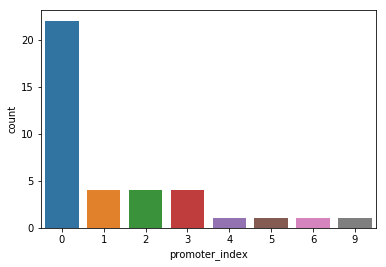

In [35]:
sns.countplot(promoterDf['promoter_index'])

In [39]:
# df에 칼럼 추가
df = pd.merge(df, promoterDf, on='youtube')
df.sort_values(by='promoter_index', ascending=False)

,name,youtube,avg_hashtag,avg_comment,avg_self_comment,post_interval,ppl_img_ratio,comment_user_num,lang_ratio,avg_likes,num_of_posts,followers,following,bio_url,avg_like_follower_ratio,promoter_index
20,__kindacool,UCYJlyU_Lf33eqp6KWYONTGg,2.4,56.9,0.0,0.833333,0.87,"{'comment1': 338, 'comment2': 52, 'comment3': ...","{'ko': '77.86', 'emoji': '22.14'}",6961.1,775,128231,299,youtu.be/0VfuYt3lB4I,0.05,9
14,on_do__,UCSn90DAxCF3yRs6mFK0-8TA,0.1,88.9,0.0,1.250000,0.28,"{'comment1': 620, 'comment2': 82, 'comment3': ...","{'ko': '84.14', 'emoji': '15.86'}",20396.2,624,240594,244,m.insideobject.com,0.08,6
24,yeseul0104,UCbDeLCyqxaZnLZDYpd5rnrA_1,0.0,66.0,0.0,2.500000,0.67,"{'comment1': 449, 'comment2': 46, 'comment3': ...","{'ko': '93.94', 'emoji': '6.06'}",8142.3,473,182582,4,NaN,0.04,5
27,real_quaddurup,UCkQCwnkQfgSuPTTnw_Y7v7w,0.4,76.5,0.0,0.909091,0.64,"{'comment1': 381, 'comment2': 73, 'comment3': ...","{'ko': '96.60', 'emoji': '3.40'}",3578.3,165,99484,318,www.zbkstore.com/product/detail.html?product_n...,0.04,4
3,its.hanbyul,UC9gW47NqzI1x7e8qsflvUUw,0.3,34.0,0.0,0.384615,0.80,"{'comment1': 194, 'comment2': 31, 'comment3': ...","{'ko': '92.65', 'emoji': '7.35'}",3133.1,110,49117,74,youtu.be/5e3kEeC2vhE,0.06,3
7,endears_o,UCENNpEHHCiZGb2dk1MHml7Q_1,2.6,190.9,0.0,0.384615,0.67,"{'comment1': 1444, 'comment2': 183, 'comment3'...","{'ko': '98.95', 'emoji': '1.05'}",10089.3,271,179601,54,goo.gl/5dpoF2,0.06,3
10,redhatsg,UCLvaHVogti2o0AkXoNZzeKA,1.6,15.6,0.3,0.026738,0.46,"{'comment1': 107, 'comment2': 18, 'comment3': ...","{'ko': '98.72', 'emoji': '1.28'}",209.1,12,2270,28,NaN,0.09,3
1,serim.hong.50,UC0ssa8zC_3oif4iZcUe5VUg,3.6,30.7,0.0,0.625000,0.81,"{'comment1': 229, 'comment2': 20, 'comment3': ...","{'ko': '98.70', 'emoji': '1.30'}",3354.2,1007,88363,510,zeezeeplanet.com,0.04,3
0,bellawithlucas,UC-Ju7Rpx4V9XsrLh2DXh9tw_1,1.6,11.7,0.5,0.256410,0.85,"{'comment1': 46, 'comment2': 16, 'comment3': 1...","{'ko': '73.50', 'emoji': '26.50'}",1115.2,87,8169,2,www.youtube.com/user/kimdonghyun3013,0.14,2
22,rappeler.iam,UCa_ZCXMQ57PDcpE_3tPOW1g,0.9,7.6,0.0,0.384615,0.80,"{'comment1': 44, 'comment2': 9, 'comment3': 0,...","{'ko': '85.53', 'emoji': '14.47'}",568.1,281,10376,1,www.youtube.com/c/ASMRrappeler20,0.05,2


In [40]:
# 우선 저장
df.to_csv('data/postNprofile_new.csv')

In [30]:
# 채린 선정 후보
candidates = ['horseking123', 'yan.youtube', 'blueskyh2', 'monkey.d.kihoon', 'real_quaddurup', 'psj9434', 'gomongtube', 'jojae____altong']
df.loc[df['name'].isin(candidates), ['name', 'promoter_index']]

,name,promoter_index
4,monkey.d.kihoon,0
8,blueskyh2,1
9,yan.youtube,2
15,jojae____altong,0
19,horseking123,0
27,real_quaddurup,4
30,psj9434,0


## Assimilation Index


In [19]:
post = get_s3(df)

In [33]:
def get_assim_list(post):
    assim_list = []
    for key, postLi in post.items():
        for p in postLi:
            item = {
                'youtube': key,
                'post_id': p.get('key'),
                'caption': p.get('caption') if p.get('caption') else '',
                'comments': [item['comment'] for item in p.get('comments') if item['comment'] != ''] 
                            if p.get('comments') else []
            }
            assim_list.append(item)
    return assim_list

assim_list = get_assim_list(post)

In [34]:
assim_list[:20]

[{'youtube': 'UC-Ju7Rpx4V9XsrLh2DXh9tw_1',
  'post_id': 'https://www.instagram.com/p/Bzsb1_LgFO3/',
  'caption': '벨루가 여러분! 즐거운 스트리밍이었어요❤️ 또만나용\n\nDear Beluga! It was really nice to see you on streaming❤️See you\n\n#벨루가라니 #어색하다😆',
  'comments': ['벨루가 됐군요!!!! 너무 좋아요😍',
   '🙋',
   '오늘 너무 좋았어요~❤️',
   '다이렉트메세지 확인 부탁드려도될까요???',
   'Omg😍😍❤️❤️❤️',
   '@bellawithlucas oppa sister',
   '💕💕',
   'Beluga❤️💙',
   'Beluga is really cute, congrats for the new fandom name😆💕💕',
   'Olá como posso adquirir a partitura de Faded à 4 mãos @bellawithlucas?',
   '으흑흑 댓글 2번이나 읽어주셔서 감사해요😭😭❤️❤️',
   'ㅎㅎ너무이뻐용^^볼수록 더 이쁜것같아용😍']},
 {'youtube': 'UC-Ju7Rpx4V9XsrLh2DXh9tw_1',
  'post_id': 'https://www.instagram.com/p/BzcrccVgnqq/',
  'caption': '내일은 무슨 곡이 업로드 될까요?\n다들 궁금하시죠? 💜💙\n-\nWhat songs will be uploaded tomorrow?\n🙋🏻\u200d♀️🙋🏻\u200d♂️💁🏻\u200d♀️💁🏻\u200d♂️ #벨라앤루카스 #bellaandlucas\n20:00 pm (KOR.) #Thursday on #youtube',
  'comments': ['I hope you cover 너를 만나 Me After You by Paul Kim 💜',
   '🙌',
   '스토리로... 맛보기 영상이

In [41]:
import re

def strip(text):
    '''
    스트링에서 '\n', '\t', '\r', '#' 기호를 공백으로 대체, 이모지 삭제
    '''
    re_symbol = re.compile('[\n\r\t#]')
#     re_emoji = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)

    return re.sub(re_symbol, ' ', text)

In [51]:
# extract nouns

from konlpy.tag import Mecab
mecab = Mecab()

for p in assim_list:
    p['cap_noun'] = ' '.join(mecab.nouns(strip(p['caption'])))
    cmt_noun_list = [noun for c in p['comments'] for noun in mecab.nouns(strip(c))]
    p['cmt_noun'] = ' '.join(cmt_noun_list)

In [55]:
# a string of nouns appeared more that once for each post
corpus = [p['cap_noun'] + ' ' + p['cmt_noun'] for p in assim_list]

In [67]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer

count_vectorizer = CountVectorizer()
count_vector = count_vectorizer.fit_transform(corpus)

tfidf_vectorizer = TfidfTransformer()
tfidf_vector = tfidf_vectorizer.fit_transform(count_vector)

In [70]:
query = assim_list[0]['cap_noun']
qcount = count_vectorizer.transform([query])
qtfidf = tfidf_transformer.transform(qcount)
comment = assim_list[0]['cmt_noun']
ccount = count_vectorizer.transform([comment])
ctfidf = tfidf_transformer.transform(ccount)

from scipy.spatial import distance
dist = distance.cosine(qtfidf.toarray(), ctfidf.toarray())
dist

1.0

벨루가 여러분 스트리밍 벨루가
벨루 다이렉트 메세지 확인 부탁 댓글 번 감사 용 것


In [73]:
print(query)
print(comment)

query = assim_list[33]['cap_noun']
qcount = count_vectorizer.transform([query])
qtfidf = tfidf_transformer.transform(qcount)
comment = assim_list[33]['cmt_noun']
ccount = count_vectorizer.transform([comment])
ctfidf = tfidf_transformer.transform(ccount)

from scipy.spatial import distance
dist = distance.cosine(qtfidf.toarray(), ctfidf.toarray())
dist

벨루가 여러분 스트리밍 벨루가
벨루 다이렉트 메세지 확인 부탁 댓글 번 감사 용 것


0.7428074815799246